# Desafio LATAM

Por Juan PINEDA-JARAMILLO
https://github.com/jdpinedaj


## Importando las librerías


In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
from datetime import datetime as dt
import requests
from pandas_profiling import ProfileReport
from math import *
import imblearn
from pycaret.classification import *
from pycaret.utils import check_metric
import shap

# SALib
from SALib.sample import saltelli
from SALib.analyze import sobol

# sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# settings to display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [2]:
# Cargando el dataset con las variables climáticas
df = pd.read_csv('../data/output/data_final.csv')

# fecha_o y fecha_i como datetime
df['fecha_o'] = pd.to_datetime(df['fecha_o'])
df['fecha_i'] = pd.to_datetime(df['fecha_i'])

# # Definiendo atraso_10 si la resta entre fecha_o y fecha_i es mayor a 30 min
# df['atraso_10'] = df['fecha_o'] - df['fecha_i']
# df['atraso_10'] = df['atraso_10'].dt.total_seconds() / 60
# df['atraso_10'] = df['atraso_10'].apply(lambda x: 1 if x > 10 else 0)
df.head()


,fecha_i,vlo_i,ori_i,des_i,emp_i,fecha_o,vlo_o,ori_o,des_o,emp_o,dia,mes,año,dianom,tipovuelo,opera,siglaori,siglades,temporada_alta,dif_min,atraso_15,periodo_dia,count_later_destino,count_later_empresa,count_later_periodo,periodo_dia_mes_dia,count_later_periodo_dia_mes_dia,tipo_aeropuerto_destino,lat_destino,lon_destino,elevacion_destino,continente_destino,pais_destino,lat_santiago,lon_santiago,elevacion_santiago,dif_vlo,dif_emp,dif_des,distancia,tavg_dest,tmin_dest,tmax_dest,prcp_dest,snow_dest,wdir_dest,wspd_dest,wpgt_dest,pres_dest,tsun_dest,tavg_santiago,tmin_santiago,tmax_santiago,prcp_santiago,snow_santiago,wdir_santiago,wspd_santiago,wpgt_santiago,pres_santiago,tsun_santiago
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,1,3.0,0,noche,107,25,1850,noche-1-1,4,large_airport,25.793200,-80.290604,2.438400,NaN,US,-33.393002,-70.785797,473.963985,0,0,0,6657.490095,24.6,21.7,28.3,0.0,NaN,117.0,15.8,NaN,1021.3,151.0,21.6,14.0,32.0,NaN,NaN,NaN,12.8,NaN,1015.7,NaN
1,2017-01-01 22:00:00,912,SCEL,KMIA,AAL,2017-01-01 22:15:00,912,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,1,15.0,0,noche,107,25,1850,noche-1-1,4,large_airport,25.793200,-80.290604,2.438400,NaN,US,-33.393002,-70.785797,473.963985,0,0,0,6657.490095,24.6,21.7,28.3,0.0,NaN,117.0,15.8,NaN,1021.3,151.0,21.6,14.0,32.0,NaN,NaN,NaN,12.8,NaN,1015.7,NaN
2,2017-01-01 22:30:00,940,SCEL,KDFW,AAL,2017-01-01 22:31:00,940,SCEL,KDFW,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Dallas,1,1.0,0,noche,16,25,1850,noche-1-1,4,large_airport,32.896801,-97.038002,185.013594,NaN,US,-33.393002,-70.785797,473.963985,0,0,0,7866.284042,11.8,6.1,18.9,1.8,0.0,NaN,9.4,NaN,1010.3,NaN,21.6,14.0,32.0,NaN,NaN,NaN,12.8,NaN,1015.7,NaN
3,2017-01-01 23:35:00,500,SCEL,KMIA,LAN,2017-01-01 23:42:00,500,SCEL,KMIA,LAN,1,1,2017,Domingo,I,Grupo LATAM,Santiago,Miami,1,7.0,0,noche,107,4580,1850,noche-1-1,4,large_airport,25.793200,-80.290604,2.438400,NaN,US,-33.393002,-70.785797,473.963985,0,0,0,6657.490095,24.6,21.7,28.3,0.0,NaN,117.0,15.8,NaN,1021.3,151.0,21.6,14.0,32.0,NaN,NaN,NaN,12.8,NaN,1015.7,NaN
4,2017-01-01 22:45:00,502,SCEL,KMIA,LAN,2017-01-01 23:02:00,502,SCEL,KMIA,LAN,1,1,2017,Domingo,I,Grupo LATAM,Santiago,Miami,1,17.0,1,noche,107,4580,1850,noche-1-1,4,large_airport,25.793200,-80.290604,2.438400,NaN,US,-33.393002,-70.785797,473.963985,0,0,0,6657.490095,24.6,21.7,28.3,0.0,NaN,117.0,15.8,NaN,1021.3,151.0,21.6,14.0,32.0,NaN,NaN,NaN,12.8,NaN,1015.7,NaN


In [3]:
df['atraso_15'].value_counts(normalize=True)

0    0.882299
1    0.117701
Name: atraso_15, dtype: float64

In [4]:
df.describe(include='all')


,fecha_i,vlo_i,ori_i,des_i,emp_i,fecha_o,vlo_o,ori_o,des_o,emp_o,dia,mes,año,dianom,tipovuelo,opera,siglaori,siglades,temporada_alta,dif_min,atraso_15,periodo_dia,count_later_destino,count_later_empresa,count_later_periodo,periodo_dia_mes_dia,count_later_periodo_dia_mes_dia,tipo_aeropuerto_destino,lat_destino,lon_destino,elevacion_destino,continente_destino,pais_destino,lat_santiago,lon_santiago,elevacion_santiago,dif_vlo,dif_emp,dif_des,distancia,tavg_dest,tmin_dest,tmax_dest,prcp_dest,snow_dest,wdir_dest,wspd_dest,wpgt_dest,pres_dest,tsun_dest,tavg_santiago,tmin_santiago,tmax_santiago,prcp_santiago,snow_santiago,wdir_santiago,wspd_santiago,wpgt_santiago,pres_santiago,tsun_santiago
count,63007,63007.0,63007,63007,63007,63007,63006,63007,63007,63007,63007.000000,63007.000000,63007.0,63007,63007,63007,63007,63007,63007.000000,63007.000000,63007.000000,63007,63007.000000,63007.000000,63007.000000,63007,63007.000000,63007,63007.000000,63007.000000,63007.000000,57708,63007,6.300700e+04,6.300700e+04,6.300700e+04,63007.000000,63007.000000,63007.000000,63007.000000,53548.000000,52257.000000,51362.000000,36036.000000,1691.000000,28173.000000,48213.000000,0.0,36644.000000,590.000000,63007.000000,61960.000000,60906.000000,58891.000000,0.0,2990.000000,59074.000000,0.0,52443.000000,0.0
unique,50025,810.0,1,61,30,58334,824,1,61,31,NaN,NaN,NaN,7,2,23,1,60,NaN,NaN,NaN,3,NaN,NaN,NaN,1095,NaN,3,NaN,NaN,NaN,3,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2017-03-26 18:00:00,150.0,SCEL,SCFA,LAN,2017-05-19 07:01:00,11,SCEL,SCFA,LAN,NaN,NaN,NaN,Jueves,N,Grupo LATAM,Santiago,Buenos Aires,NaN,NaN,NaN,mañana,NaN,NaN,NaN,tarde-11-12,NaN,medium_airport,NaN,NaN,NaN,SA,CL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,6,529.0,63007,5464,35241,5,634,63007,5463,19568,NaN,NaN,NaN,9427,34772,38165,63007,5679,NaN,NaN,NaN,23828,NaN,NaN,NaN,83,NaN,40684,NaN,NaN,NaN,55659,34772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2017-01-01 00:15:00,NaN,NaN,NaN,NaN,2017-01-01 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2017-12-31 23:55:00,NaN,NaN,NaN,NaN,2017-12-31 23:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.727697,6.562017,2017.0,NaN,NaN,NaN,NaN,NaN,0.332439,4.707858,0.117701,NaN,375.326710,3106.285079,2548.630565,NaN,7.115939,NaN,-21.919809,-66.157752,399.942412,NaN,NaN,-3.339300e+01,-7.078580e+01,4.739640e+02,0.496294,0.273557,0.000349,2157.552005,17.185198,13.457543,21.996028,2.329898,5.293318,178.488588,12.962968,NaN,1015.094957,380.913559,15.746169,8.731761,24.599122,0.478279,NaN,176.243813,10.369061,NaN,1016.195805,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.817121,3.530607,0.0,NaN,NaN,NaN,NaN,NaN,0.471091,8.414519,0.322257,NaN,258.548683,1875.956409,457.033585,NaN,4.559688,NaN,20.814627,24.769017,748.068418,NaN,NaN,7.105484e-15,1.421097e-14,5.684387e-14,0.499990,0.445788,0.018683,2331.734730,6.020129,6.440862,6.343105,7.820840,72.298962,90.262072,6.033471,NaN,26.088926,192.994773,5.793088,4.988452,6.815233,2.102000,NaN,7.371408,3.452598,NaN,3.276040,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,2017.0,NaN,NaN,NaN,NaN,NaN,0.000000,-14.000000,0.000000,NaN,0.000000,5.000000,1850.000000,NaN,0.000000,NaN,-54.843300,-118.407997,2.438400,NaN,NaN,-3.339300e+01,-7.078580e+01,4.739640e+02,0.000000,0.000000,0.000000,195.820849,-10.100000,-20.800000,-7.300000,0.000000,0.000000,0.000000,0.000000,NaN,938.600000,0.000000,3.500000,-3.800000,9.00

# Data imputation

In [5]:
data_final = df.copy()


# Eliminando variables climaticas que no se utilizarán por falta de datos
weather_feat_dest = ['tavg_dest', 'tmin_dest', 'tmax_dest', 'prcp_dest',
                     'snow_dest', 'wdir_dest', 'wspd_dest', 'wpgt_dest', 'pres_dest', 'tsun_dest']
weather_feat_santiago = ['tavg_santiago', 'tmin_santiago', 'tmax_santiago', 'prcp_santiago',
                         'snow_santiago', 'wdir_santiago', 'wspd_santiago', 'wpgt_santiago', 'pres_santiago', 'tsun_santiago']


# data imputation using median value for the same mes and siglades for [tavg_dest, tmin_dest, tmax_dest, wspd_dest, tavg_santiago, tmin_santiago, tmax_santiago, prcp_santiago, wspd_santiago, pres_santiago]
data_final['tavg_dest'].fillna(data_final.groupby(['mes', 'siglades'])[
                               'tavg_dest'].transform('median'), inplace=True)
data_final['tmin_dest'].fillna(data_final.groupby(['mes', 'siglades'])[
                               'tmin_dest'].transform('median'), inplace=True)
data_final['tmax_dest'].fillna(data_final.groupby(['mes', 'siglades'])[
                               'tmax_dest'].transform('median'), inplace=True)
data_final['wspd_dest'].fillna(data_final.groupby(['mes', 'siglades'])[
                               'wspd_dest'].transform('median'), inplace=True)
data_final['tavg_santiago'].fillna(data_final.groupby(['mes', 'siglades'])[
                                   'tavg_santiago'].transform('median'), inplace=True)
data_final['tmin_santiago'].fillna(data_final.groupby(['mes', 'siglades'])[
                                   'tmin_santiago'].transform('median'), inplace=True)
data_final['tmax_santiago'].fillna(data_final.groupby(['mes', 'siglades'])[
                                   'tmax_santiago'].transform('median'), inplace=True)
data_final['prcp_santiago'].fillna(data_final.groupby(['mes', 'siglades'])[
                                   'prcp_santiago'].transform('median'), inplace=True)
data_final['wspd_santiago'].fillna(data_final.groupby(['mes', 'siglades'])[
                                   'wspd_santiago'].transform('median'), inplace=True)
data_final['pres_santiago'].fillna(data_final.groupby(['mes', 'siglades'])[
                                   'pres_santiago'].transform('median'), inplace=True)


# Data imputation para continente
for i, j, k in zip(data_final['siglades'], data_final['pais_destino'], data_final['continente_destino']):
    if j == 'US':
        data_final['continente_destino'] = data_final['continente_destino'].fillna('NA')
    elif j == 'MX':
        data_final['continente_destino'] = data_final['continente_destino'].fillna('NA')
    elif j == 'CA':
        data_final['continente_destino'] = data_final['continente_destino'].fillna('NA')
    elif j == 'PA':
        data_final['continente_destino'] = data_final['continente_destino'].fillna('SA')
    elif j == 'DO':
        data_final['continente_destino'] = data_final['continente_destino'].fillna('SA')


# Filling with median value
for i in data_final.columns:
    if data_final[i].dtype == 'float64':
        data_final[i].fillna(data_final[i].median(), inplace=True)
    elif data_final[i].dtype == 'int64':
        data_final[i].fillna(data_final[i].median(), inplace=True)
    elif data_final[i].dtype == 'object':
        data_final[i].fillna(data_final[i].mode()[0], inplace=True)
    else:
        pass

# Drop variables innecesarias

data_final.drop(columns=['prcp_dest', 'snow_dest', 'wdir_dest', 'wpgt_dest', 'pres_dest',
                'tsun_dest', 'snow_santiago',	'wdir_santiago', 'wpgt_santiago', 'tsun_santiago'], inplace=True)

data_final.describe(include='all')


,fecha_i,vlo_i,ori_i,des_i,emp_i,fecha_o,vlo_o,ori_o,des_o,emp_o,dia,mes,año,dianom,tipovuelo,opera,siglaori,siglades,temporada_alta,dif_min,atraso_15,periodo_dia,count_later_destino,count_later_empresa,count_later_periodo,periodo_dia_mes_dia,count_later_periodo_dia_mes_dia,tipo_aeropuerto_destino,lat_destino,lon_destino,elevacion_destino,continente_destino,pais_destino,lat_santiago,lon_santiago,elevacion_santiago,dif_vlo,dif_emp,dif_des,distancia,tavg_dest,tmin_dest,tmax_dest,wspd_dest,tavg_santiago,tmin_santiago,tmax_santiago,prcp_santiago,wspd_santiago,pres_santiago
count,63007,63007.0,63007,63007,63007,63007,63007,63007,63007,63007,63007.000000,63007.000000,63007.0,63007,63007,63007,63007,63007,63007.000000,63007.000000,63007.000000,63007,63007.000000,63007.000000,63007.000000,63007,63007.000000,63007,63007.000000,63007.000000,63007.000000,63007,63007,6.300700e+04,6.300700e+04,6.300700e+04,63007.000000,63007.000000,63007.000000,63007.000000,63007.000000,63007.000000,63007.000000,63007.000000,63007.000000,63007.000000,63007.000000,63007.000000,63007.000000,63007.000000
unique,50025,810.0,1,61,30,58334,824,1,61,31,NaN,NaN,NaN,7,2,23,1,60,NaN,NaN,NaN,3,NaN,NaN,NaN,1095,NaN,3,NaN,NaN,NaN,4,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2017-03-26 18:00:00,150.0,SCEL,SCFA,LAN,2017-05-19 07:01:00,11,SCEL,SCFA,LAN,NaN,NaN,NaN,Jueves,N,Grupo LATAM,Santiago,Buenos Aires,NaN,NaN,NaN,mañana,NaN,NaN,NaN,tarde-11-12,NaN,medium_airport,NaN,NaN,NaN,SA,CL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,6,529.0,63007,5464,35241,5,635,63007,5463,19568,NaN,NaN,NaN,9427,34772,38165,63007,5679,NaN,NaN,NaN,23828,NaN,NaN,NaN,83,NaN,40684,NaN,NaN,NaN,55659,34772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2017-01-01 00:15:00,NaN,NaN,NaN,NaN,2017-01-01 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2017-12-31 23:55:00,NaN,NaN,NaN,NaN,2017-12-31 23:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.727697,6.562017,2017.0,NaN,NaN,NaN,NaN,NaN,0.332439,4.707858,0.117701,NaN,375.326710,3106.285079,2548.630565,NaN,7.115939,NaN,-21.919809,-66.157752,399.942412,NaN,NaN,-3.339300e+01,-7.078580e+01,4.739640e+02,0.496294,0.273557,0.000349,2157.552005,17.189146,13.467210,21.935770,12.646566,15.746169,8.751938,24.642931,0.447037,10.420240,1016.182903
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.817121,3.530607,0.0,NaN,NaN,NaN,NaN,NaN,0.471091,8.414519,0.322257,NaN,258.548683,1875.956409,457.033585,NaN,4.559688,NaN,20.814627,24.769017,748.068418,NaN,NaN,7.105484e-15,1.421097e-14,5.684387e-14,0.499990,0.445788,0.018683,2331.734730,5.660883,6.074256,5.939724,5.655394,5.793088,4.984494,6.769879,2.035615,3.456035,3.118358
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,2017.0,NaN,NaN,NaN,NaN,NaN,0.000000,-14.000000,0.000000,NaN,0.000000,5.000000,1850.000000,NaN,0.000000,NaN,-54.843300,-118.407997,2.438400,NaN,NaN,-3.339300e+01,-7.078580e+01,4.739640e+02,0.000000,0.000000,0.000000,195.820849,-10.100000,-20.800000,-7.300000,0.000000,3.500000,-3.800000,9.000000,0.000000,3.900000,1009.900000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,3.000000,2017.0,NaN,NaN,NaN,NaN,NaN,0.000000,-1.000000,0.000000,NaN,206.000000,1477.000000,2534.000000,NaN,4.000000,NaN,-34.822200,-73.094002,34.442399,NaN,NaN,-3.339300e+01,-7.078580e+01,4.739640e+02,0.000000,0.000000,0.000000,917.489520,13.800000,9.600000,18.400000,9.400000,10.300000,4.800000,18.600000,0.000000,7.500000,1013.700000


# Modelos

In [6]:
data_model = data_final.copy()
data_model.drop(columns=[
    'fecha_i', 'vlo_i', 'ori_i', 'des_i', 'emp_i', 'fecha_o', 'vlo_o', 'ori_o',
    'des_o', 'emp_o', 'año', 'siglaori', 'dif_min', 'lat_destino',
    'lon_destino', 'lat_santiago', 'lon_santiago', 'elevacion_santiago', 'periodo_dia_mes_dia', 'pais_destino'
],
    inplace=True)

# Dropping null values
# data_model.dropna(inplace=True)

data_model.describe(include='all')


,dia,mes,dianom,tipovuelo,opera,siglades,temporada_alta,atraso_15,periodo_dia,count_later_destino,count_later_empresa,count_later_periodo,count_later_periodo_dia_mes_dia,tipo_aeropuerto_destino,elevacion_destino,continente_destino,dif_vlo,dif_emp,dif_des,distancia,tavg_dest,tmin_dest,tmax_dest,wspd_dest,tavg_santiago,tmin_santiago,tmax_santiago,prcp_santiago,wspd_santiago,pres_santiago
count,63007.000000,63007.000000,63007,63007,63007,63007,63007.000000,63007.000000,63007,63007.000000,63007.000000,63007.000000,63007.000000,63007,63007.000000,63007,63007.000000,63007.000000,63007.000000,63007.000000,63007.000000,63007.000000,63007.000000,63007.000000,63007.000000,63007.000000,63007.000000,63007.000000,63007.000000,63007.000000
unique,NaN,NaN,7,2,23,60,NaN,NaN,3,NaN,NaN,NaN,NaN,3,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Jueves,N,Grupo LATAM,Buenos Aires,NaN,NaN,mañana,NaN,NaN,NaN,NaN,medium_airport,NaN,SA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,9427,34772,38165,5679,NaN,NaN,23828,NaN,NaN,NaN,NaN,40684,NaN,55659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,15.727697,6.562017,NaN,NaN,NaN,NaN,0.332439,0.117701,NaN,375.326710,3106.285079,2548.630565,7.115939,NaN,399.942412,NaN,0.496294,0.273557,0.000349,2157.552005,17.189146,13.467210,21.935770,12.646566,15.746169,8.751938,24.642931,0.447037,10.420240,1016.182903
std,8.817121,3.530607,NaN,NaN,NaN,NaN,0.471091,0.322257,NaN,258.548683,1875.956409,457.033585,4.559688,NaN,748.068418,NaN,0.499990,0.445788,0.018683,2331.734730,5.660883,6.074256,5.939724,5.655394,5.793088,4.984494,6.769879,2.035615,3.456035,3.118358
min,1.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,5.000000,1850.000000,0.000000,NaN,2.438400,NaN,0.000000,0.000000,0.000000,195.820849,-10.100000,-20.800000,-7.300000,0.000000,3.500000,-3.800000,9.000000,0.000000,3.900000,1009.900000
25%,8.000000,3.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,206.000000,1477.000000,2534.000000,4.000000,NaN,34.442399,NaN,0.000000,0.000000,0.000000,917.489520,13.800000,9.600000,18.400000,9.400000,10.300000,4.800000,18.600000,0.000000,7.500000,1013.700000
50%,16.000000,7.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,377.000000,4580.000000,2534.000000,6.000000,NaN,89.611197,NaN,0.000000,0.000000,0.000000,1225.395827,17.000000,14.000000,21.400000,11.600000,15.800000,9.000000,25.800000,0.000000,10.500000,1015.800000
75%,23.000000,10.000000,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,524.000000,4580.000000,3032.000000,10.000000,NaN,204.215993,NaN,1.000000,1.000000,0.000000,2461.893077,20.800000,17.400000,26.000000,14.500000,20.900000,12.600000,30.400000,0.000000,13.500000,1018.300000


In [7]:
data_model.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63007 entries, 0 to 63006
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   dia                              63007 non-null  int64  
 1   mes                              63007 non-null  int64  
 2   dianom                           63007 non-null  object 
 3   tipovuelo                        63007 non-null  object 
 4   opera                            63007 non-null  object 
 5   siglades                         63007 non-null  object 
 6   temporada_alta                   63007 non-null  int64  
 7   atraso_15                        63007 non-null  int64  
 8   periodo_dia                      63007 non-null  object 
 9   count_later_destino              63007 non-null  int64  
 10  count_later_empresa              63007 non-null  int64  
 11  count_later_periodo              63007 non-null  int64  
 12  count_later_period

In [8]:
data_model['atraso_15'].value_counts(normalize=True)


0    0.882299
1    0.117701
Name: atraso_15, dtype: float64

In [9]:
# Dividiendo los datos en variables categóricas, variables numéricas y la variable objetivo (target)
target = data_model['atraso_15']
cat_vars = data_model.select_dtypes(['object', 'category'])
num_vars = data_model.select_dtypes(['float64',
                                     'int64']).drop(columns=['atraso_15'])

# Se realiza un One hot encoding para las variables categóricas
enc = OneHotEncoder(drop='first')
enc.fit(cat_vars)
cat_vars_ohe = enc.transform(cat_vars).toarray()
cat_vars_ohe = pd.DataFrame(cat_vars_ohe,
                            index=cat_vars.index,
                            columns=enc.get_feature_names(
                                cat_vars.columns.tolist()))

# Se normalizan las variables numéricas
scaler = StandardScaler()
num_vars_norm = scaler.fit_transform(num_vars)
num_vars_norm = pd.DataFrame(num_vars_norm,
                             index=num_vars.index,
                             columns=num_vars.columns)

# Se combinan las transformaciones realizadas a las variables categóricas y numéricas
data_model_ohe = pd.concat([num_vars_norm, cat_vars_ohe], axis=1)
data_model_ohe.head()


,dia,mes,temporada_alta,count_later_destino,count_later_empresa,count_later_periodo,count_later_periodo_dia_mes_dia,elevacion_destino,dif_vlo,dif_emp,dif_des,distancia,tavg_dest,tmin_dest,tmax_dest,wspd_dest,tavg_santiago,tmin_santiago,tmax_santiago,prcp_santiago,wspd_santiago,pres_santiago,dianom_Jueves,dianom_Lunes,dianom_Martes,dianom_Miercoles,dianom_Sabado,dianom_Viernes,tipovuelo_N,opera_Aeromexico,opera_Air Canada,opera_Air France,opera_Alitalia,opera_American Airlines,opera_Austral,opera_Avianca,opera_British Airways,opera_Copa Air,opera_Delta Air,opera_Gol Trans,opera_Grupo LATAM,opera_Iberia,opera_JetSmart SPA,opera_K.L.M.,opera_Lacsa,opera_Latin American Wings,opera_Oceanair Linhas Aereas,opera_Plus Ultra Lineas Aereas,opera_Qantas Airways,opera_Sky Airline,opera_United Airlines,siglades_Arica,siglades_Asuncion,siglades_Atlanta,siglades_Auckland N.Z.,siglades_Balmaceda,siglades_Bariloche,siglades_Bogota,siglades_Buenos Aires,siglades_Calama,siglades_Cancun,siglades_Castro (Chiloe),siglades_Cataratas Iguacu,siglades_Ciudad de Mexico,siglades_Ciudad de Panama,siglades_Concepcion,siglades_Copiapo,siglades_Cordoba,"siglades_Curitiba, Bra.",siglades_Dallas,siglades_Florianapolis,siglades_Guayaquil,siglades_Houston,siglades_Iquique,siglades_Isla de Pascua,siglades_La Paz,siglades_La Serena,siglades_Lima,siglades_Londres,siglades_Los Angeles,siglades_Madrid,siglades_Melbourne,siglades_Mendoza,siglades_Miami,siglades_Montevideo,siglades_Neuquen,siglades_Nueva York,siglades_Orlando,siglades_Osorno,siglades_Paris,"siglades_Pisco, Peru",siglades_Puerto Montt,siglades_Puerto Natales,siglades_Punta Arenas,siglades_Punta Cana,siglades_Punta del Este,siglades_Quito,siglades_Rio de Janeiro,siglades_Roma,siglades_Rosario,"siglades_San Juan, Arg.",siglades_Santa Cruz,siglades_Sao Paulo,siglades_Sydney,siglades_Temuco,siglades_Toronto,siglades_Tucuman,siglades_Ushuia,siglades_Valdivia,siglades_Washington,periodo_dia_noche,periodo_dia_tarde,tipo_aeropuerto_destino_medium_airport,tipo_aeropuerto_destino_small_airport,continente_destino_NA,continente_destino_OC,continente_destino_SA
0,-1.670365,-1.575384,1.417063,-1.037827,-1.642527,-1.528632,-0.683372,-0.531378,-0.992615,-0.613653,-0.018689,1.929882,1.309144,1.355369,1.071478,0.557602,1.010493,1.052886,1.086744,-0.219609,0.688587,-0.15486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.670365,-1.575384,1.417063,-1.037827,-1.642527,-1.528632,-0.683372,-0.531378,-0.992615,-0.613653,-0.018689,1.929882,1.309144,1.355369,1.071478,0.557602,1.010493,1.052886,1.086744,-0.219609,0.688587,-0.15486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-1.670365,-1.575384,1.417063,-1.389795,-1.642527,-1.528632,-0.683372,-0.287314,-0.992615,-0.613653,-0.018689,2.448296,-0.952005,-1.212868,-0.511100,-0.574070,1.010493,1.052886,1.086744,-0.219609,0.688587,-0.15486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-1.670365,-1.575384,1.417063,-1.037827,0.785587,-1.528632,-0.683372,-0.531378,-0.992615,-0.613653,-0.018689,1.92

#### Probando una simple regresión logística para predicción

In [10]:
data_model_ohe.shape

(63007, 117)

In [11]:
# División de datos de entrenamiento y test estratificado por la variable objetivo (target)
X_train, X_test, y_train, y_test = train_test_split(data_model_ohe,
                                                    target,
                                                    test_size=0.2,
                                                    stratify=target,
                                                    random_state=42,
                                                    shuffle=True)

# Aplicando método SMOTE para resamplear la clase minoritaria (vuelos atrasados)

sm = imblearn.over_sampling.SMOTE()
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)
y_train_res = pd.DataFrame(y_train_res, columns=['atraso_15'])

# training the model
lr = LogisticRegression()
lr.fit(X_train_res, y_train_res)

# Calculando métricas de accuracy, precision, recall y auc score
print('Accuracy:', round(accuracy_score(y_test, lr.predict(X_test)), 2))
print('Precision:', round(precision_score(y_test, lr.predict(X_test)), 2))
print('Recall:', round(recall_score(y_test, lr.predict(X_test)), 2))
print('AUC score:', round(roc_auc_score(y_test, lr.predict(X_test)), 2))


Accuracy: 0.68
Precision: 0.21
Recall: 0.63
AUC score: 0.66


# Definiendo diferentes métrodos de resampleo para probar
RandomUnderSampler = imblearn.under_sampling.RandomUnderSampler()
Smote = imblearn.over_sampling.SMOTE()
RandomOverSampler = imblearn.over_sampling.RandomOverSampler()
Smoteen = imblearn.combine.SMOTEENN()

# Aplicando los diferentes métodos de resampleo y verificando sus resultados en las métricas previamente evaluadas
sampling_methods = [RandomUnderSampler, Smote, RandomOverSampler, Smoteen]
for method in sampling_methods:
    X_train_res, y_train_res = method.fit_sample(X_train, y_train)
    X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)
    y_train_res = pd.DataFrame(y_train_res, columns=['atraso_15'])
    lr.fit(X_train_res, y_train_res)
    print(method)
    print('Accuracy:', round(accuracy_score(y_test, lr.predict(X_test)), 2))
    print('Precision:', round(precision_score(y_test, lr.predict(X_test)), 2))
    print('Recall:', round(recall_score(y_test, lr.predict(X_test)), 2))
    print('AUC score:', round(roc_auc_score(y_test, lr.predict(X_test)), 2))
    print('\n')


Se selecciona el metodo SMOTEENN para generar el oversampling de los datos.


#### Entrenando más modelos utilizando la librería Pycaret.


In [9]:
data_model.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63007 entries, 0 to 63006
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   dia                              63007 non-null  int64  
 1   mes                              63007 non-null  int64  
 2   dianom                           63007 non-null  object 
 3   tipovuelo                        63007 non-null  object 
 4   opera                            63007 non-null  object 
 5   siglades                         63007 non-null  object 
 6   temporada_alta                   63007 non-null  int64  
 7   atraso_15                        63007 non-null  int64  
 8   periodo_dia                      63007 non-null  object 
 9   count_later_destino              63007 non-null  int64  
 10  count_later_empresa              63007 non-null  int64  
 11  count_later_periodo              63007 non-null  int64  
 12  count_later_period

Con el objetivo de demostrar la predicción del modelo (predict_model()) en datos no_vistos, una muestra del 5% de las observaciones son separadas del dataset original y será usada para posterior validación de las predicciones. Esto no debe ser confundido con la división training/test debido a que esta división particular es realizada para simular un escenario de la vida real. Otra forma de pensarlo es que este 5% de las observaciones no estarán disponibles en el momento en que los experimentos de Machine Learning son realizados.


In [11]:
# TABLE WITH DESCRIPTIVE STATISTICS

# Numerical features
statistics_numeric = data_model.describe().transpose().reset_index()
statistics_numeric.rename(columns={'50%': 'median'}, inplace=True)
statistics_numeric['statistics'] = 'mean: ' + round(
    statistics_numeric['mean'], 2).astype(str) + ', median: ' + round(
        statistics_numeric['median'], 2).astype(str) + ', min: ' + round(
            statistics_numeric['min'], 2).astype(str) + ', max: ' + round(
                statistics_numeric['max'], 2).astype(str)

# Categorical features
statistics_categorical = data_model.describe(include='O').transpose().reset_index()
statistics_categorical['statistics'] = statistics_categorical['index'].apply(
    lambda x: ', '.join(data_model[x].value_counts().reset_index()[
        'index'] + ': ' + round(data_model[x].value_counts(normalize=True) * 100, 1).
                        astype(str).reset_index()[x] + '%'))

# Concatenating both numeric and categorical features
statistics = pd.concat([statistics_categorical, statistics_numeric], axis=0)
statistics[['index', 'unique',
            'statistics']].to_csv('../data/output/descriptive_statistics.csv',
                                  index=False)

statistics[['index', 'unique', 'statistics']]

,index,unique,statistics
0,dianom,7,"Jueves: 15.0%, Viernes: 14.8%, Lunes: 14.7%, D..."
1,tipovuelo,2,"N: 55.2%, I: 44.8%"
2,opera,23,"Grupo LATAM: 60.6%, Sky Airline: 21.0%, Copa A..."
3,siglades,60,"Buenos Aires: 9.0%, Antofagasta: 8.7%, Calama:..."
4,periodo_dia,3,"mañana: 37.8%, tarde: 37.2%, noche: 25.0%"
5,tipo_aeropuerto_destino,3,"medium_airport: 64.6%, large_airport: 35.1%, s..."
6,continente_destino,4,"SA: 88.3%, NA: 8.4%, EU: 2.5%, OC: 0.7%"
0,dia,NaN,"mean: 15.73, median: 16.0, min: 1.0, max: 31.0"
1,mes,NaN,"mean: 6.56, median: 7.0, min: 1.0, max: 12.0"
2,temporada_alta,NaN,"mean: 0.33, median: 0.0, min: 0.0, max: 1.0"


In [12]:
for i in data_model[[
        'dianom', 'tipovuelo', 'opera',
        'siglades', 'periodo_dia', 'tipo_aeropuerto_destino', 'continente_destino'
]].columns:
    print(i, '\n', data_model[i].value_counts(normalize=True))
    print('---------------------------------\n')

dianom 
 Jueves       0.149618
Viernes      0.148476
Lunes        0.146698
Domingo      0.145444
Miercoles    0.143317
Martes       0.142683
Sabado       0.123764
Name: dianom, dtype: float64
---------------------------------

tipovuelo 
 N    0.551875
I    0.448125
Name: tipovuelo, dtype: float64
---------------------------------

opera 
 Grupo LATAM                 0.605726
Sky Airline                 0.210056
Copa Air                    0.028838
Aerolineas Argentinas       0.027378
Latin American Wings        0.019490
JetSmart SPA                0.016284
Avianca                     0.016062
American Airlines           0.011602
Gol Trans                   0.010665
Air Canada                  0.006571
Iberia                      0.005587
Air France                  0.005587
Delta Air                   0.005555
Aeromexico                  0.005523
United Airlines             0.005126
Oceanair Linhas Aereas      0.004000
Alitalia                    0.003952
K.L.M.                      0

In [13]:
data = data_model.sample(frac=0.95, random_state=786)
data_unseen = data_model.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))


Data for Modeling: (59857, 30)
Unseen Data For Predictions: (3150, 30)


In [10]:
data.columns


NameError: name 'data' is not defined

In [ ]:
exp = setup(
    data=data,  # dataframe with target variable
    target='atraso_15',
    ignore_features=['opera', 'siglades',
                     'continente_destino'],  # features to ignore in the model
    numeric_features=[
        'dia', 'mes', 'temporada_alta', 'count_later_destino', 'count_later_empresa', 'count_later_periodo', 'count_later_periodo_dia_mes_dia', 'elevacion_destino', 'dif_vlo', 'dif_emp', 
        'dif_des', 'distancia', 'tavg_dest', 'tmin_dest', 'tmax_dest', 'wspd_dest', 'tavg_santiago', 'tmin_santiago', 'tmax_santiago', 'prcp_santiago', 'wspd_santiago', 'pres_santiago'
    ],  # numerical features to use in the model
    session_id=42,
    normalize=True,
    normalize_method='zscore',
    transformation=True,
    use_gpu=True,
    fix_imbalance=True,  # fix imbalance by oversampling minority class
    fix_imbalance_method=imblearn.combine.SMOTEENN(),
    # split data into training and testing data stratified by target variable
    data_split_stratify=True,
    fold=5,  # number of folds for cross validation
    fold_strategy='stratifiedkfold',  # cross validation strategy
    silent=True,
    # log_experiment=True,
    # experiment_name='exp,
)


,Description,Value
0,session_id,42
1,Target,atraso_15
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(59857, 30)"
5,Missing Values,False
6,Numeric Features,22
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [16]:
X_train = get_config('X_train')
X_train

,dia,mes,temporada_alta,count_later_destino,count_later_empresa,count_later_periodo,count_later_periodo_dia_mes_dia,elevacion_destino,dif_vlo,dif_emp,...,dianom_Miercoles,dianom_Sabado,dianom_Viernes,tipovuelo_N,periodo_dia_mañana,periodo_dia_noche,periodo_dia_tarde,tipo_aeropuerto_destino_large_airport,tipo_aeropuerto_destino_medium_airport,tipo_aeropuerto_destino_small_airport
47133,0.147669,-0.446419,-0.709260,1.163061,0.802906,-1.403310,-0.658799,-0.716661,-0.992794,-0.614731,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
55816,-0.990720,-0.725358,-0.709260,-1.461132,-1.417652,1.148801,-0.067310,-0.948151,1.007258,1.626728,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
49826,-0.534579,1.563309,-0.709260,-0.484191,-1.404174,1.148801,1.774445,0.051945,1.007258,-0.614731,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
35437,-0.876607,-1.278704,1.409921,0.306554,-1.082200,-0.210396,-1.734965,-0.616523,-0.992794,-0.614731,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
55706,-1.219086,-1.553517,1.409921,0.486802,0.802906,1.148801,-0.067310,-0.308710,1.007258,1.626728,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12251,-0.306859,0.980443,-0.709260,0.643655,-1.398965,1.148801,0.410162,1.561795,1.007258,-0.614731,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
33526,1.166212,-1.553517,1.409921,0.721501,0.802906,-1.403310,0.186218,0.005267,-0.992794,1.626728,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
27383,-1.104881,-0.165561,-0.709260,-0.484191,0.802906,-0.210396,1.115913,0.051945,-0.992794,1.626728,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
8925,0.827193,1.271245,-0.709260,0.721501,-1.382329,1.148801,1.774445,0.005267,1.007258,1.626728,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [17]:
# Los mejores modelos para clasificación binaria son seleccionados

# PRECAUCIÓN: ESTA CELDA ES MUY DEMORADA DE CORRER

best_models = compare_models(
    turbo=False,
    sort='recall',
    round=3,
    include=['lr', 'knn', 'dt', 'rf', 'gbc', 'lightgbm', 'catboost'])


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.538,0.707,0.787,0.175,0.287,0.116,0.189,178.186
knn,K Neighbors Classifier,0.576,0.642,0.664,0.169,0.270,0.101,0.148,242.742
gbc,Gradient Boosting Classifier,0.718,0.717,0.556,0.222,0.317,0.179,0.209,236.184
lightgbm,Light Gradient Boosting Machine,0.806,0.730,0.384,0.273,0.319,0.210,0.214,231.470
dt,Decision Tree Classifier,0.732,0.581,0.382,0.188,0.252,0.112,0.122,215.820
rf,Random Forest Classifier,0.771,0.681,0.370,0.220,0.276,0.150,0.157,214.922
catboost,CatBoost Classifier,0.810,0.723,0.360,0.270,0.309,0.201,0.204,234.732


La tabla anterior presenta los resultados de los modelos entrenados en el cross_validation data set, utilizando un fold de 5.
Son resaltados en amarillo los mejores resultados para cada métrica en cada modelo.

La métrica más importante a tener en cuenta es el recall, que, debido a que la variable objetivo `atraso_15` es binario (siendo 1 los vuelos que son retrasados), el recall representa la cantidad de true positives para esta clase, y por tanto, lo más importante para predecir desde el punto de vista del negocio.

Así pues, el modelo Logistic Regression es elegido para realizar un análisis más detallado.


#### Logistic regression model


In [18]:
lr = create_model(estimator='lr')

# Los resultados presentados son en el data set de cross-validación, debido a que se implementó la metodología K-fold cross-validation (con k = 5)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5443,0.7162,0.8018,0.1796,0.2934,0.1246,0.2014
1,0.5425,0.7087,0.7776,0.1755,0.2863,0.1161,0.1864
2,0.5376,0.7107,0.7897,0.1756,0.2873,0.1167,0.1898
3,0.5356,0.7021,0.7968,0.1759,0.2882,0.1176,0.1923
4,0.5307,0.6972,0.7702,0.1704,0.2791,0.1065,0.1739
Mean,0.5381,0.7070,0.7872,0.1754,0.2869,0.1163,0.1888
Std,0.0049,0.0066,0.0118,0.0029,0.0046,0.0058,0.0090


El modelo da unos resultados aceptables, pero se procede a optimizarlo, con el objetivo de mejorar la metrica recall, debido a que es mas importante predecir los vuelos que efectivamente estan retrasados.


#### Tuned logistic regression model


In [19]:
# Tunenado los hiperparámetros del modelo de regresión logística para optimizar la métrica recall

# PRECAUCIÓN: ESTA CELDA ES MUY DEMORADA DE CORRER

tuned_lr = tune_model(lr,
                      optimize='recall',
                      n_iter=80,
                      early_stopping=True,
                      choose_better=True)

# Los resultados presentados son en el data set de cross-validación


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5442,0.7162,0.8008,0.1794,0.2931,0.1242,0.2007
1,0.5425,0.7087,0.7776,0.1755,0.2863,0.1161,0.1864
2,0.5374,0.7107,0.7897,0.1755,0.2872,0.1166,0.1896
3,0.5354,0.7021,0.7958,0.1757,0.2879,0.1172,0.1917
4,0.5307,0.6972,0.7702,0.1704,0.2791,0.1065,0.1739
Mean,0.5380,0.7070,0.7868,0.1753,0.2867,0.1161,0.1885
Std,0.0049,0.0067,0.0114,0.0029,0.0045,0.0056,0.0087


El modelo mejora levemente la métrica recall con esta técnica.


In [20]:
# Prediciendo en el data set de testeo
test_holdout_set = predict_model(estimator=tuned_lr)
test_holdout_set.head()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5479,0.7040,0.7721,0.1765,0.2873,0.1178,0.1872


,dia,mes,temporada_alta,count_later_destino,count_later_empresa,count_later_periodo,count_later_periodo_dia_mes_dia,elevacion_destino,dif_vlo,dif_emp,...,tipovuelo_N,periodo_dia_mañana,periodo_dia_noche,periodo_dia_tarde,tipo_aeropuerto_destino_large_airport,tipo_aeropuerto_destino_medium_airport,tipo_aeropuerto_destino_small_airport,atraso_15,Label,Score
0,-1.219086,0.691079,-0.709260,0.196119,-1.082200,-1.403310,-0.658799,1.932163,-0.992794,-0.614731,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0,0.6666
1,1.279129,-0.725358,-0.709260,-0.530931,-1.396349,-1.403310,-0.067310,1.945314,-0.992794,-0.614731,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,1,0.6869
2,0.827193,-1.278704,1.409921,-0.610044,-1.082200,-1.403310,-0.349575,-0.588533,-0.992794,-0.614731,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0,0.6830
3,0.261089,-0.446419,-0.709260,0.486802,0.802906,-0.210396,1.262142,-0.308710,-0.992794,1.626728,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0,1,0.7145
4,1.053252,0.980443,-0.709260,-0.599409,0.802906,1.148801,0.959934,1.248897,1.007258,-0.614731,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,1,0.8711


#### Finalizando el modelo y guardándolo


In [21]:
# Finalizando el modelo con los mejores hiperparámetros
final_lr = finalize_model(tuned_lr)

# Guardando el modelo
save_model(final_lr, '../models/final_lr')


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['opera', 'siglades',
                                                        'continente_destino'],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['dia', 'mes',
                                                           'temporada_alta',
                                                           'count_later_destino',
                                                           'count_later_empresa',
                                                           'count_later_periodo',
                                                           'count_later_periodo_dia_mes_dia...
                 ('feature_select', 'passthrough'), ('fi

In [22]:
# Prediciendo el los datos no_vistos, utilizando el modelo finalizado
unseen_predictions = predict_model(final_lr, data=data_unseen)
unseen_predictions.head()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5632,0.7061,0.7507,0.1706,0.2781,0.1168,0.1831


,dia,mes,dianom,tipovuelo,opera,siglades,temporada_alta,atraso_15,periodo_dia,count_later_destino,...,tmax_dest,wspd_dest,tavg_santiago,tmin_santiago,tmax_santiago,prcp_santiago,wspd_santiago,pres_santiago,Label,Score
0,1,1,Domingo,I,Grupo LATAM,Buenos Aires,1,0,noche,964,...,35.0,11.1,21.6,14.0,32.0,0.0,12.8,1015.7,1,0.6739
1,1,1,Domingo,I,Grupo LATAM,Lima,1,0,noche,675,...,26.9,13.0,21.6,14.0,32.0,0.0,12.8,1015.7,1,0.5784
2,2,1,Lunes,I,Grupo LATAM,Buenos Aires,1,1,noche,964,...,33.4,16.2,23.8,16.0,31.0,0.0,14.3,1014.3,1,0.8084
3,2,1,Lunes,I,Grupo LATAM,Rio de Janeiro,1,1,noche,230,...,35.0,11.4,23.8,16.0,31.0,0.0,14.3,1014.3,1,0.7400
4,2,1,Lunes,I,Grupo LATAM,Lima,1,0,noche,675,...,27.3,18.0,23.8,16.0,31.0,0.0,14.3,1014.3,1,0.8222


In [23]:
# Verificando las métricas al calcularlas en los datos de testeo y los datos no_vistos
print(
    'Recall test/holdout data:',
    check_metric(test_holdout_set['atraso_15'],
                 test_holdout_set['Label'],
                 metric='Recall'))
print(
    'Recall unseen data:',
    check_metric(unseen_predictions['atraso_15'],
                 unseen_predictions['Label'],
                 metric='Recall'))


Recall test/holdout data: 0.7721
Recall unseen data: 0.7507


#### Conclusiones

Como los resultados entre el cross_calidation set, el test/holdout data set y el unseen data set son similares, se puede considerar que el modelo no está sobreajustado.\
Además, el modelo es capaz de predecir la probabilidad de atraso de un vuelo (mirar la columna `Score` con las predicciones).


### Desafio 5

Evalúa tu modelo.


- ¿Qué performance tiene?


In [24]:
X_test = get_config('X_test')
y_test = get_config('y_test')

# Métrica recall
print('Recall: ', round(recall_score(y_test, tuned_lr.predict(X_test)), 2))


Recall:  0.77


En este problema de clasificación binario, el valor 1 ha sido asignado a la clase de `vuelos retrasados`, por lo que la variable recall presentado anteriormente representa específicamente los vuelos que realmente fueron retrasados y que el modelo también predijo como retrasados (TRUE POSITIVES).

Como se mencionó anteriormente, es importante tener un recall alto (alto porcentaje de TRUE POSITIVES), dado que de esta forma es posible entender las variables que influyen en que un vuelo sea retrasado o no, y poder entender el fenómeno para poder tomar decisiones.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


[Text(0, 0.5, 'no_retrasados'), Text(0, 1.5, 'retrasados')]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


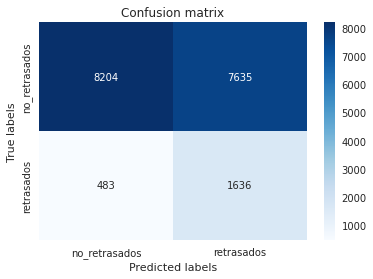

In [25]:
# Gráfica de la matriz de confusión
ax = plt.subplot()
sns.heatmap(confusion_matrix(y_test, tuned_lr.predict(X_test)),
            annot=True,
            fmt='d',
            cmap='Blues',
            ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['no_retrasados', 'retrasados'])
ax.yaxis.set_ticklabels(['no_retrasados', 'retrasados'])


Otra forma de medir el performance de un modelo es la matriz de confusion, que muestra la cantidad de veces que un modelo predice que un vuelo es retrasado (1) y que un vuelo no es retrasado (0).\
 Adicionalmente, la matriz de confuisión muestra la cantidad de falsos positivos y falsos negativos, que son los que realmente son retrasados y el modelo predice lo contrario (33% de los vuelos retrasados), y los que realmente no son retrasados y el modelo predice que son retrasados (35% de los vuelos no retrasados).


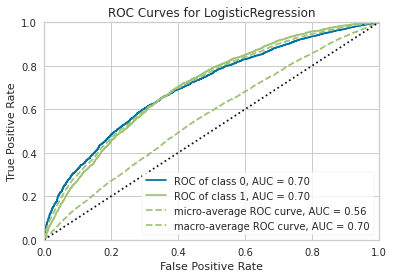

In [26]:
# Gráfica de AUC
plot_model(estimator=tuned_lr, plot='auc')


Finalmente, se presentan los resultados de la curva ROC (Receiver Operating Characteristic), que muestra el performance del modelo de clasificación en todos los umbrales de clasificación.
Esta curva presenta el True Positive Rate (TPR) frente al False Positive Rate (FPR). El area bajo la curva es lo que se conoce como el AUC (Area Under the Curve), que mide el area entera bajo la curva, donde un valor mayor representa una mejor clasificación.


- ¿Qué métricas usaste para evaluar esa performance y por qué?


Tal como se explicó anteriormente, las métricas utilizadas para evaluar el performance para este problema de clasificación binario fueron el recall, Matriz de confusión y curva ROC con el AUC.
Estas métricas fueron elegidos por dos motivos principalmente:

- El dataset de entrenamiento estaba un poco desbalanceado (siendo los vuelos retrasados únicamente el 11.7% de los datos), por lo que utilizar el accuracy no tenía mucho sentido, dado que un modelo hipotético que predijera SIEMPRE que un vuelo iba a ser NO RETRASADO, sería un modelo con casi el 90% de accuracy, pero un modelo que no serviría para predecir vuelos retrasados, y por lo tanto un modelo inútil que no serviría para tomar decisiones con el fin de reducir la probabilidad de que un vuelo fuera retrasado (mediante el estudio del impacto de las variables que inciden en esta probabilidad).
- Por otro lado, el AUC y la matriz de confusión son unas métricas que permiten evaluar cada una de las clases por separado (en este caso vuelos retrasados, y vuelos no retrasados), con el fin de entender el performance del modelo de clasificación para cada una de las clases por separado.


- ¿Por qué elegiste ese algoritmo en particular?


Como se vio anteriormente, 5 modelos fueron elegidos inicialmente para construir el modelo de clasificación:

- Regrésion logística
- Árbol de decisión
- K Nearest Neighbors
- Random Forest
- Gradient Boosting (incluyendo 3 frameworks: el de sklearn, el catboost y el lightgbm)

Estos modelos fueron elegidos porque en el estado del arte son modelos que son ampliamente utilizados para resolver problemas de clasificación binaria, obteniendo buenos resultados.


- ¿Qué variables son las que más influyen en la predicción?


El impacto de las variables en la predicción del modelo se obtiene utilizando la metodología SHapley Additive exPlanation (SHAP). Este método permite identificar el efecto directo y el impacto de cada una de las variables utilizadas para entrenar el mejor modelo ML, obteniendo el nivel de impacto de las variables que inducen a la predicción de un vuelo retrasado.

Este método calcula las diferencias promedio de las predicciones en todos los órdenes probables de las variables de predicción utilizando como base las explicaciones precisas para generar valores SHAP, permitiendo extraer la valor del impacto y el efecto directo que cada característica tiene sobre la inducción de un vuelo retrasado.

Para mayor información, se pueden consultar las siguientes referencias:

- Lundberg, S., & Lee, S.-I. (2017). A Unified Approach to Interpreting Model Predictions. Proceedings of the 31st International Conference on Neural Information Processing Systems, 4768–4777. https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions

- Parsa, A. B., Movahedi, A., Taghipour, H., Derrible, S., & Mohammadian, A. (Kouros). (2020). Toward safer highways, application of XGBoost and SHAP for real-time accident detection and feature analysis. Accident Analysis and Prevention, 136(October 2019), 105405. https://doi.org/10.1016/j.aap.2019.105405

- Xu, J., Wang, A., Schmidt, N., Adams, M., & Hatzopoulou, M. (2020). A gradient boost approach for predicting near-road ultrafine particle concentrations using detailed traffic characterization. Environmental Pollution, 265, 114777. https://doi.org/10.1016/j.envpol.2020.114777


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


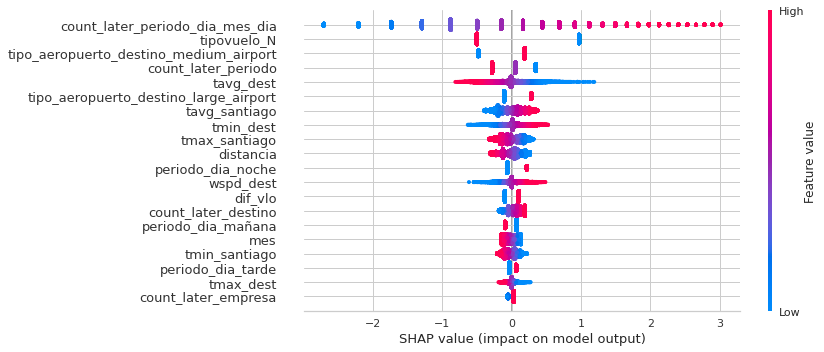

In [27]:
# Visualizando el impacto de las variables utilizando la metodología SHAP

# shap Explainer
X_test = get_config('X_test')
masker = shap.maskers.Independent(data=X_test)
explainer = shap.LinearExplainer(model=tuned_lr,
                                 masker=masker,
                                 feature_names=X_test.columns,
                                 algorithm="linear")
shap_values = explainer.shap_values(X_test)

# summary plot
shap.summary_plot(shap_values, X_test, plot_size=(12, 5))


La gráfica anterior utiliza la metodología SHAP para identificar la importancia de las variables en la predicción del modelo.
Las variables presentadas están ordenadas según el impacto general estimado por los valores SHAP, donde se puede observar que las variables que tienen un mayor impacto son la cantidad de vuelos retrasados que llegan al aeropuerto en el mismo día y período de tiempo (count_later_periodo_dia_mes_dia), la cantidad de vuelos que llegan tarde históricamente en el mismo período de tiempo (count_later_periodo), el tipo de aeropuerto de destino (tipo_aeropuerto_destino_medium_airport), vuelos que llegan en un periodo del día determinado (periodo_dia_mañana), y el país de destino de los vuelos, específicamente en Argentinay Chile.

Llama la atención que la distancia no es una variable importante en la predicción para el modelo entrenado, auqnue el país de destino si lo es.

Por otro lado, es importante mencionar que la variable count_later_periodo_dia_mes_dia podría tener un uso en la predicción únicamente si se requiere realizar modelos de predicción a corto plazo, más no a largo plazo. Pero debido a que no hay una claridad de esta especificación en el desafío, se incluye.


- ¿Cómo podrías mejorar la performance?


Se podria incluir otras variables adicionales, como numero de vuelos que llegan a los aeropuertos estudiados con origenes diferentes de Santiago, retraso en la salida de los vuelos, etc.


# Analisis de sensibilidad usando SALib

In [29]:
model = tuned_lr
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
X = get_config('X')
X.head()

,dia,mes,temporada_alta,count_later_destino,count_later_empresa,count_later_periodo,count_later_periodo_dia_mes_dia,elevacion_destino,dif_vlo,dif_emp,dif_des,distancia,tavg_dest,tmin_dest,tmax_dest,wspd_dest,tavg_santiago,tmin_santiago,tmax_santiago,prcp_santiago,wspd_santiago,pres_santiago,dianom_Domingo,dianom_Jueves,dianom_Lunes,dianom_Martes,dianom_Miercoles,dianom_Sabado,dianom_Viernes,tipovuelo_N,periodo_dia_mañana,periodo_dia_noche,periodo_dia_tarde,tipo_aeropuerto_destino_large_airport,tipo_aeropuerto_destino_medium_airport,tipo_aeropuerto_destino_small_airport
0,-1.104881,-1.002709,-0.709260,-0.901399,0.802906,-0.210396,-0.658799,0.360000,-0.992794,1.626728,-0.018924,-1.001722,0.319933,0.544020,0.185987,0.001296,1.142132,0.677739,1.121261,-0.300950,-0.277264,-1.526223,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-1.447622,0.117689,-0.709260,1.163061,0.802906,1.148801,0.792269,-0.716661,1.007258,-0.614731,-0.018924,0.800012,0.248191,0.617447,-0.166757,1.084873,-1.190921,-0.376478,-1.127827,-0.300950,-0.448546,0.659484,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,-0.534579,-0.446419,-0.709260,1.163061,-1.382329,-1.403310,-0.349575,-0.716661,-0.992794,1.626728,-0.018924,0.800012,1.121982,1.284652,1.377517,1.275929,-0.528261,0.428064,-1.251042,3.430825,-0.448546,-0.826028,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,-1.104881,1.271245,-0.709260,-1.374422,0.802906,-0.210396,1.530873,1.308870,1.007258,1.626728,-0.018924,-0.045183,-0.883569,-1.172204,-1.342789,2.659139,0.475166,0.573323,0.406669,-0.300950,1.071199,-0.016549,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-0.534579,-1.553517,1.409921,0.643655,0.802906,1.148801,0.410162,1.561795,1.007258,-0.614731,-0.018924,0.876667,1.177394,1.304310,1.344688,-0.689940,1.355920,1.271324,1.299604,-0.300950,0.714236,-1.025938,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [47]:
# Defining the problem to apply SALib to the model
problem = {
    'num_vars': 36,
    'names': [X.columns[i] for i in range(36)],
    'bounds': [[X[col].min(), X[col].max()] for col in X.columns]
}


        

In [39]:
# Generating samples
param_values = saltelli.sample(problem, 100000)

In [40]:
# Samples to a dataframe
param_values = pd.DataFrame(param_values, columns=X.columns)

# Saving the samples
# param_values.to_csv('../data/output/param_values.csv', index=False) # This file is too big
print(param_values.shape)
param_values.head()

(7400000, 36)


,dia,mes,temporada_alta,count_later_destino,count_later_empresa,count_later_periodo,count_later_periodo_dia_mes_dia,elevacion_destino,dif_vlo,dif_emp,dif_des,distancia,tavg_dest,tmin_dest,tmax_dest,wspd_dest,tavg_santiago,tmin_santiago,tmax_santiago,prcp_santiago,wspd_santiago,pres_santiago,dianom_Domingo,dianom_Jueves,dianom_Lunes,dianom_Martes,dianom_Miercoles,dianom_Sabado,dianom_Viernes,tipovuelo_N,periodo_dia_mañana,periodo_dia_noche,periodo_dia_tarde,tipo_aeropuerto_destino_large_airport,tipo_aeropuerto_destino_medium_airport,tipo_aeropuerto_destino_small_airport
0,-1.676271,-0.774299,0.782867,-0.196538,-0.161827,-0.964637,-0.366333,-0.017681,0.100824,-0.465328,2.686588,0.462747,-0.48535,-3.638701,-1.920354,-1.129203,0.783262,0.21972,-1.377712,2.789501,-0.772134,1.850099,0.522228,0.220516,0.315517,0.520206,0.929173,0.43745,0.527096,0.590405,0.273632,0.704929,0.033466,0.960705,0.799824,0.850628
1,0.719132,-0.774299,0.782867,-0.196538,-0.161827,-0.964637,-0.366333,-0.017681,0.100824,-0.465328,2.686588,0.462747,-0.48535,-3.638701,-1.920354,-1.129203,0.783262,0.21972,-1.377712,2.789501,-0.772134,1.850099,0.522228,0.220516,0.315517,0.520206,0.929173,0.43745,0.527096,0.590405,0.273632,0.704929,0.033466,0.960705,0.799824,0.850628
2,-1.676271,-0.588629,0.782867,-0.196538,-0.161827,-0.964637,-0.366333,-0.017681,0.100824,-0.465328,2.686588,0.462747,-0.48535,-3.638701,-1.920354,-1.129203,0.783262,0.21972,-1.377712,2.789501,-0.772134,1.850099,0.522228,0.220516,0.315517,0.520206,0.929173,0.43745,0.527096,0.590405,0.273632,0.704929,0.033466,0.960705,0.799824,0.850628
3,-1.676271,-0.774299,1.350431,-0.196538,-0.161827,-0.964637,-0.366333,-0.017681,0.100824,-0.465328,2.686588,0.462747,-0.48535,-3.638701,-1.920354,-1.129203,0.783262,0.21972,-1.377712,2.789501,-0.772134,1.850099,0.522228,0.220516,0.315517,0.520206,0.929173,0.43745,0.527096,0.590405,0.273632,0.704929,0.033466,0.960705,0.799824,0.850628
4,-1.676271,-0.774299,0.782867,0.933338,-0.161827,-0.964637,-0.366333,-0.017681,0.100824,-0.465328,2.686588,0.462747,-0.48535,-3.638701,-1.920354,-1.129203,0.783262,0.21972,-1.377712,2.789501,-0.772134,1.850099,0.522228,0.220516,0.315517,0.520206,0.929173,0.43745,0.527096,0.590405,0.273632,0.704929,0.033466,0.960705,0.799824,0.850628


In [41]:
# Predicting the model with the samples
y_pred = model.predict_proba(param_values)[:, 1]
y_pred

array([0.30667353, 0.30442519, 0.30321542, ..., 0.69907682, 0.69749881,
       0.72465177])

In [42]:
# Performing the sensitivity analysis
Si = sobol.analyze(problem, y_pred, print_to_console=True)

                                              ST       ST_conf
dia                                     0.000005  6.515083e-08
mes                                     0.001567  2.139941e-05
temporada_alta                          0.000034  4.847438e-07
count_later_destino                     0.002945  3.776739e-05
count_later_empresa                     0.000190  2.216368e-06
count_later_periodo                     0.008249  1.158813e-04
count_later_periodo_dia_mes_dia         0.606125  7.123276e-03
elevacion_destino                       0.000071  9.650423e-07
dif_vlo                                 0.000815  1.150891e-05
dif_emp                                 0.000173  2.155804e-06
dif_des                                 0.288659  3.817068e-03
distancia                               0.006680  9.592950e-05
tavg_dest                               0.083761  1.143633e-03
tmin_dest                               0.037992  5.210181e-04
tmax_dest                               0.004705  6.369

In [44]:
print(Si['ST'])

[4.73666374e-06 1.56685854e-03 3.38495189e-05 2.94502322e-03
 1.90202826e-04 8.24927360e-03 6.06124967e-01 7.13168577e-05
 8.15325939e-04 1.72545419e-04 2.88658830e-01 6.67984286e-03
 8.37609270e-02 3.79915194e-02 4.70483755e-03 2.50792290e-02
 1.20854084e-02 3.78972856e-03 8.37258725e-03 2.83683414e-05
 3.64224210e-04 4.92615229e-05 2.19968657e-04 7.95380649e-05
 3.66548564e-06 1.94631961e-04 3.28113180e-05 5.06607434e-04
 2.20631456e-04 4.47512594e-02 5.63495755e-04 1.65951113e-03
 2.07621022e-04 3.18552556e-03 9.18993568e-03 1.46004737e-02]


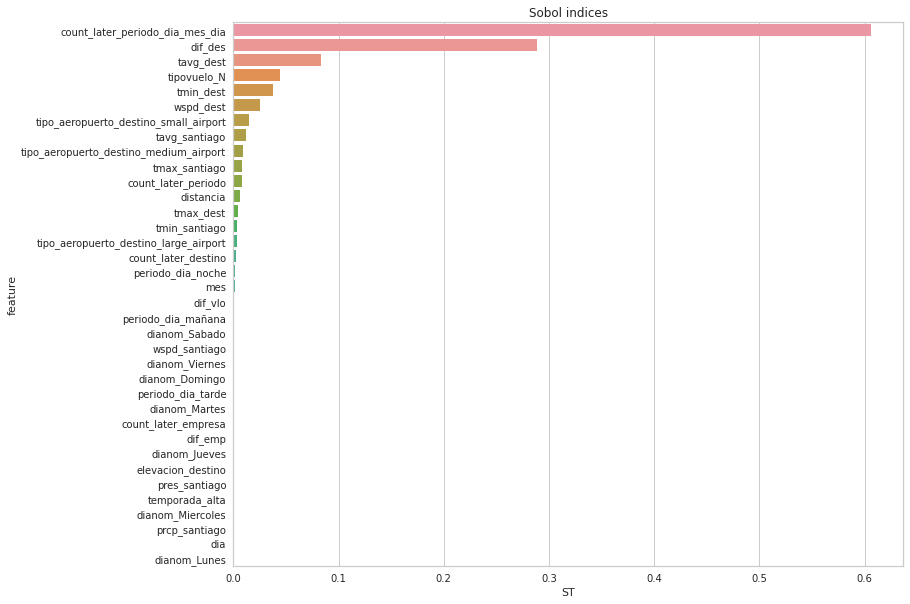

In [51]:
# Showing both the features and the indices, ordered by the indices
Si_df = pd.DataFrame({'feature': X.columns, 'ST': Si['ST']})
Si_df = Si_df.sort_values(by='ST', ascending=False)

# Plotting the indices using seaborn
plt.figure(figsize=(12, 10))
sns.barplot(x='ST', y='feature', data=Si_df)
plt.title('Sobol indices')
plt.show()


In [45]:
print(Si)

{'S1': array([-3.69706862e-06,  8.43686345e-04,  1.54277773e-05,  1.80682262e-03,
        1.11848380e-04,  5.05398099e-03,  4.89787784e-01,  4.41292617e-05,
        4.88923666e-04,  9.45829464e-05,  2.02223583e-01,  4.33446681e-03,
        5.46903900e-02,  2.44804439e-02,  3.05922663e-03,  1.59706587e-02,
        7.86712874e-03,  2.50929061e-03,  5.84143979e-03,  2.04800251e-05,
        2.03554643e-04,  2.11540552e-05,  1.15758122e-04,  4.31436017e-05,
        5.63439988e-06,  1.17381003e-04, -8.89855098e-06,  3.36559996e-04,
        1.73257946e-04,  2.94248101e-02,  3.37876144e-04,  1.13023145e-03,
        1.64048331e-04,  2.17518311e-03,  5.89119962e-03,  9.03394840e-03]), 'S1_conf': array([1.88902210e-05, 3.49749799e-04, 4.78833447e-05, 5.13200970e-04,
       1.29577011e-04, 7.87337830e-04, 6.98482699e-03, 7.38487600e-05,
       2.44825146e-04, 1.14469824e-04, 4.21466564e-03, 6.42014230e-04,
       2.21811804e-03, 1.61636796e-03, 6.11667934e-04, 1.45599588e-03,
       8.62581470e-04